## ERAD 2022 Open Source Workshop

### LROSE workflow - combining NEXRAD radars, computing PID and Ecco

Ecco is a new convective/stratiform partition algorithm in LROSE. It identifies shallow, mid and deep convection.

In this case the input data is:

- MRMS - Multi-Radar Multi-Sensor reflectivity mosaic from Taiwan radar network
- GFS - global model for temperature profile

We carry out the following steps:

- Pull example data from ncar/lrose-example-data on GitHub.
- For a single radar volume, plot the composite and a N/S and E/W cross section of reflectivity.
- For a single model time, plot a N/S and W/E cross section of temperature.
- Run Ecco for a single time.
- Plot a 2-D representation (composite) of the 3-D Ecco result.


### Initialize python

In [2]:
#
# Extra packages to be added to anaconda3 standard packages for this notebook:
#
#  conda update --all
#  conda install cartopy netCDF4
#  conda install -c conda-forge arm_pyart
#

import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import pytz
import math
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
import netCDF4 as nc
import pyart


### Download data sets from GitHub

In [6]:
# Download input data sets
#
# 1. MRMS radar mosaic grid, Taiwan domain
# 2. GFS model data for temperature profile, Taiwan domain
#
# These will be put in:
#  /tmp/lrose_data/taiwan_mrms
#

!/bin/rm -rf /tmp/lrose_data/taiwan_mrms
!mkdir -p /tmp/lrose_data/taiwan_mrms
!cd /tmp/lrose_data/taiwan_mrms; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_gfs.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_mrms.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; tar xvfz taiwan_gfs.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; tar xvfz taiwan_mrms.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; /bin/rm -f *tgz


--2022-08-18 14:53:57--  https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_gfs.example.20220608_120000.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39991495 (38M) [application/octet-stream]
Saving to: 'taiwan_gfs.example.20220608_120000.tgz'

taiwan_gfs.example. 100%[===================>]  38.14M   111MB/s    in 0.3s    

2022-08-18 14:53:58 (111 MB/s) - 'taiwan_gfs.example.20220608_120000.tgz' saved [39991495/39991495]

--2022-08-18 14:53:58--  https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_mrms.example.20220608_120000.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to ra

## Convert raw nexrad files to CfRadial format

Note that we can use environment variables in the parameter files.

In [3]:
# View the param file
!cat ./params/RadxConvert.nexrad

/**********************************************************************
 * TDRP params for RadxConvert
 **********************************************************************/

//======================================================================
//
// Converts files between CfRadial and other radial formats.
//
//======================================================================
 
//======================================================================
//
// DEBUGGING.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
// If set, debug messages will be printed appropriately.
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA
//

debug = DEBUG_OFF;

///////////// instance ////////////////////////////////
//
// Program instance for process registration.
// This application registers with procmap. This is the instance used 
// 

In [10]:
# Convert raw data to cfradial for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxConvert using param file
    !RadxConvert -params ./params/RadxConvert.nexrad -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"


Program 'RadxConvert'
Run-time 2022/08/21 03:11:25.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to 

  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/KGLD/20210706/tmp.26899.1661051498.626610.tmp
     to final path: /tmp/lrose_data/nexrad/cfradial/KGLD/20210706/cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/lrose_data/nexrad/cfradial/KGLD/20210706/cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad/raw/KGLD/20210706/KGLD20210706_222834_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad/raw/KGLD/20210706/KGLD20210706_222834_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data

INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad/raw/KUEX/20210706/KUEX20210706_222102_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad/raw/KUEX/20210706/KUEX20210706_222102_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/KUEX
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad/cfradial/KUEX
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad/cfradial/KUEX/20210706/cfrad.20210706_222102.216_to_20210706_222523.504_KUEX_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad/cfradial/KUEX/20210706/tmp.26966.1661051512.294429.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/KUEX/20210706/tmp.26966.166

  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/KDDC/20210706/tmp.27013.1661051524.414356.tmp
     to final path: /tmp/lrose_data/nexrad/cfradial/KDDC/20210706/cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/lrose_data/nexrad/cfradial/KDDC/20210706/cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad/raw/KDDC/20210706/KDDC20210706_222051_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad/raw/KDDC/20210706/KDDC20210706_222051_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/KDDC
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data

## List the CfRadial files created by RadxConvert

In [11]:
# List the CfRadial files created
!ls -R /tmp/lrose_data/nexrad/cfradial

/tmp/lrose_data/nexrad/cfradial:
KDDC  KGLD  KUEX

/tmp/lrose_data/nexrad/cfradial/KDDC:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/KDDC/20210706:
cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
cfrad.20210706_220430.757_to_20210706_220912.758_KDDC_SUR.nc
cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
cfrad.20210706_222051.218_to_20210706_222526.565_KDDC_SUR.nc
cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc

/tmp/lrose_data/nexrad/cfradial/KGLD:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/KGLD/20210706:
cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
cfrad.20210706_220448.793_to_20210706_220926.383_KGLD_SUR.nc
cfrad.20210706_220935.631_to_20210706_22

### Read in temperature field from RUC model, to provide temperature profile for PID and Ecco

In [49]:
filePathModel = '/tmp/lrose_data/nexrad/mdv/ruc/bounded/20210706/20210706_230000.mdv.cf.nc'
dsModel = nc.Dataset(filePathModel)
print(dsModel)
dstemp = dsModel['TMP']
temp3D = np.array(dstemp)
fillValueTemp = dstemp._FillValue
if (len(temp3D.shape) == 4):
    temp3D = temp3D[0]

# Compute time

uTimeSecsModel = dsModel['start_time'][0]
startTimeModel = datetime.datetime.fromtimestamp(int(uTimeSecsModel))
startTimeStrModel = startTimeModel.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time model: ", startTimeStrModel)

# Compute Model grid limits
(nZModel, nYModel, nXModel) = temp3D.shape
lon = np.array(dsModel['x0'])
lat = np.array(dsModel['y0'])
ht = np.array(dsModel['z0'])
dLonModel = lon[1] - lon[0]
dLatModel = lat[1] - lat[0]
minLonModel = lon[0] - dLonModel / 2.0
maxLonModel = lon[-1] + dLonModel / 2.0
minLatModel = lat[0] - dLatModel / 2.0
maxLatModel = lat[-1] + dLatModel / 2.0
minHtModel = ht[0]
maxHtModel = ht[-1]
print("nZModel, nYModel, nXModel", nZModel, nYModel, nXModel)
print("minLonModel, maxLonModel: ", minLonModel, maxLonModel)
print("minLatModel, maxLatModel: ", minLatModel, maxLatModel)
print("minHt, maxHt: ", minHtModel, maxHtModel)
print("Model hts: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/21 03:33:17
  Ncf:comment: 

    source: Grib2
    title: RUC Rapid Refresh
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(139), y0(72), z0(32), nbytes_mdv_chunk_0000(174)
    variables(dimensions): float64 time(time), float64 forecast_reference_time(time), float64 forecast_period(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int8 mdv_chunk_0000(time, nbytes_mdv_chunk_0000), float32 TMP(time, z0, y0, x0), float32 RH(time, z0, y0, x0), float32 UGRD(time, z0, y0, x0), float32 VGRD(time, z0, y0, x0), float32 VVEL(time, z0, y0, x0), float32 HGT(time, z0, y0, x0), float32 Pressure(time, z0, y0, x0)
    groups: 
Start time model:  2021/07/06-17:00:00 UTC
nZModel, nYModel, nXModel 32 72 139
minLonModel, maxLo

In [50]:
# Compute Temp N-S vertical section
nXHalfModel = int(nXModel/2)
tempVertNS = temp3D[:, :, nXHalfModel:(nXHalfModel+1)]
tempVertNS = tempVertNS.reshape(tempVertNS.shape[0], tempVertNS.shape[1])
tempVertNS[tempVertNS == fillValueTemp] = np.nan
print(tempVertNS.shape)
tempNSMax = np.amax(temp3D, (2))
tempNSMax[tempNSMax == fillValueTemp] = np.nan

# Compute Temp W-E vertical section
nYHalfModel = int(nYModel/2)
tempVertWE = temp3D[:, nYHalfModel:(nYHalfModel+1), :]
print(tempVertWE.shape)
tempVertWE = tempVertWE.reshape(tempVertWE.shape[0], tempVertWE.shape[2])
tempVertWE[tempVertWE == fillValueTemp] = np.nan
tempWEMax = np.amax(temp3D, (1))
tempWEMax[tempWEMax == fillValueTemp] = np.nan
print(tempVertWE.shape)

(32, 72)
(32, 1, 139)
(32, 139)


Text(0.5, 1.0, 'Vert slice mid W-E temp: 2021/07/06-17:00:00 UTC')

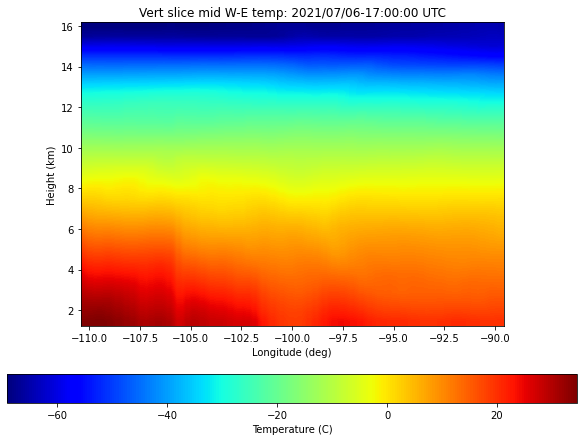

In [53]:
# Plot W-E temp vertical section
figWETemp = plt.figure(num=1, figsize=[8, 6], layout='constrained')
axWETemp = figWETemp.add_subplot(1, 1, 1, xlim = (minLonModel, maxLonModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertWE,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonModel, maxLonModel, minHtModel, maxHtModel))
axWETemp.set_aspect(1.0)
axWETemp.set_xlabel('Longitude (deg)')
axWETemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E temp: " + startTimeStrModel)

Text(0.5, 1.0, 'Vert slice mid N-S temp: 2021/07/06-17:00:00 UTC')

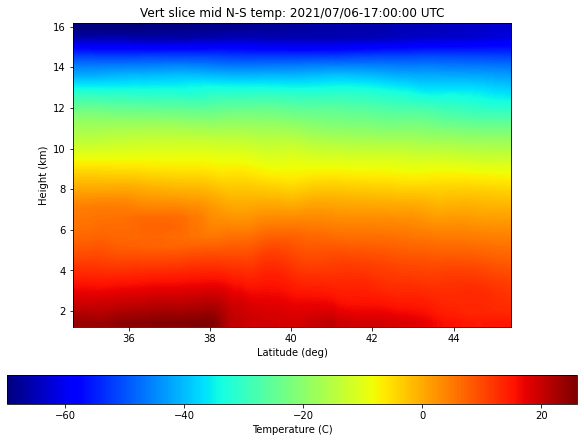

In [54]:
# Plot N-S temp vertical section
figNSTemp = plt.figure(num=1, figsize=[8, 6], layout='constrained')
axNSTemp = figNSTemp.add_subplot(1, 1, 1, xlim = (minLatModel, maxLatModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertNS,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatModel, maxLatModel, minHtModel, maxHtModel))
axNSTemp.set_aspect(0.5)
axNSTemp.set_xlabel('Latitude (deg)')
axNSTemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid N-S temp: " + startTimeStrModel)

## Read in one of the NEXRAD Goodland radar (KGLD) CfRadial files

In [61]:
radar_kgld = pyart.io.read('/tmp/lrose_data/nexrad/cfradial/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc')
radar_kgld.info('compact')
# try out 'compact', standard' or 'full' also 

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	DBZ: <ndarray of type: float32 and shape: (6120, 912)>
	VEL: <ndarray of type: float32 and shape: (6120, 912)>
	WIDTH: <ndarray of type: float32 and shape: (6120, 912)>
	ZDR: <ndarray of type: float32 and shape: (6120, 912)>
	PHIDP: <ndarray of type: float32 and shape: (6120, 912)>
	RHOHV: <ndarray of type: float32 and shape: (6120, 912)>
fixed_angle: <ndarray of type: float32 and shape: (14,)>
instrument_parameters:
	follow_mode: <ndarray of type: |S1 and shape: (14, 32)>
	pulse_width: <ndarray of type: float32 and shape: (6120,)>
	prt_mode: <ndarray of type: |S1 and shape: (14, 32)>
	prt: <ndarray of type: float32 and shape: (6120,)>
	prt_ratio: <ndarray of type: float32 and shape: (6120,)>
	pol

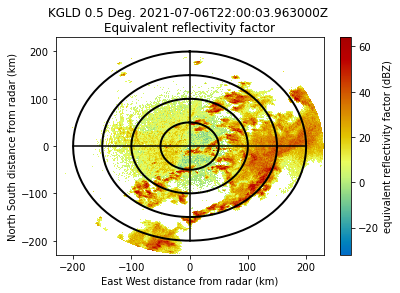

In [65]:
# Setup the display, which automatically detects this is a ppi scan
displayKgld = pyart.graph.RadarDisplay(radar_kgld)
figKgld = plt.figure()
axKgld = figKgld.add_subplot(111)
displayKgld.plot('DBZ', 0, vmin=-32, vmax=64.)
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)
plt.show()

## Read in example radar mosaic from CF-netCDF file

In [7]:
# Read in example radar mosaic for a single time

filePathMosaic = '/tmp/lrose_data/nexrad/mdv/ruc/20210706/20210706_230000.mdv.cf.nc'
dsMosaic = nc.Dataset(filePathMosaic)
print("Radar mosaic data set: ", dsMosaic)

# Compute time

uTimeSecs = dsMosaic['start_time'][0]
startTime = datetime.datetime.fromtimestamp(int(uTimeSecs))
startTimeStr = startTime.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time: ", startTimeStr)

# print(dsMosaic['DBZ'])
#for dim in dsMosaic.dimensions.values():
#    print(dim)
#for var in dsMosaic.variables.values():
#    print("========================================")
#    print(var)
#    print("========================================")

# create 3D dbz array with nans for missing vals

dsDbz = dsMosaic['DBZ']
dbz3D = np.array(dsDbz)
fillValue = dsDbz._FillValue
# print("fillValue: ", fillValue)

# if 4D (i.e. time is dim0) change to 3D

if (len(dbz3D.shape) == 4):
    dbz3D = dbz3D[0]

# Compute mosaic grid limits

(nZMosaic, nYMosaic, nXMosaic) = dbz3D.shape
lon = np.array(dsMosaic['x0'])
lat = np.array(dsMosaic['y0'])
ht = np.array(dsMosaic['z0'])
dLonMosaic = lon[1] - lon[0]
dLatMosaic = lat[1] - lat[0]
minLonMosaic = lon[0] - dLonMosaic / 2.0
maxLonMosaic = lon[-1] + dLonMosaic / 2.0
minLatMosaic = lat[0] - dLatMosaic / 2.0
maxLatMosaic = lat[-1] + dLatMosaic / 2.0
minHtMosaic = ht[0]
maxHtMosaic = ht[-1]

print("minLonMosaic, maxLonMosaic: ", minLonMosaic, maxLonMosaic)
print("minLatMosaic, maxLatMosaic: ", minLatMosaic, maxLatMosaic)
print("minHt, maxHt: ", minHtMosaic, maxHtMosaic)
print("hts: ", ht)
del lon, lat, ht

# Compute column-max reflectivity

dbzPlaneMax = np.amax(dbz3D, (0))
dbzPlaneMax[dbzPlaneMax == fillValue] = np.nan

print("Shape of composite DBZ grid: ", dbzPlaneMax.shape)
#print(dbzPlaneMax[dbzPlaneMax != np.nan])
#print(np.min(dbzPlaneMax[dbzPlaneMax != np.nan]))
#print(np.max(dbzPlaneMax))


Radar mosaic data set:  <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: This MDV file was created by CwbRadar2Mdv.
    source: RCWF RCHL RCCG RCKT RCCK ISHI RCGI RCLY RCNT RCSL 
    title: 3D radar data mosaic from Taiwan CWB.
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(441), y0(561), z0(21)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int16 DBZ(time, z0, y0, x0)
    groups: 
Start time:  2022/06/08-06:00:00 UTC
minLonMosaic, maxLonMosaic:  117.9937515258789 123.5062484741211
minLatMosaic, maxLatMosaic:  19.993749618530273 27.006250381469727
minHt, maxHt:  1.0 17.0
hts:  [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  12.  13.  14.  15.  16.  17. ]
Shape of composite DBZ grid:  (561, 441)


### Create map for Cartesian grid plotting

In [8]:
# Create map for plotting lat/lon grids
def new_map(fig):
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    ## Set extent the same as radar mosaic
    ax.set_extent([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'weight': 'bold'}
    
    return ax

### Plot column-max reflectivity in plan view, and a N/S and W/E cross section of reflectivity

Text(0.5, 1.0, 'Radar mosaic column-max DBZ: 2022/06/08-06:00:00 UTC')

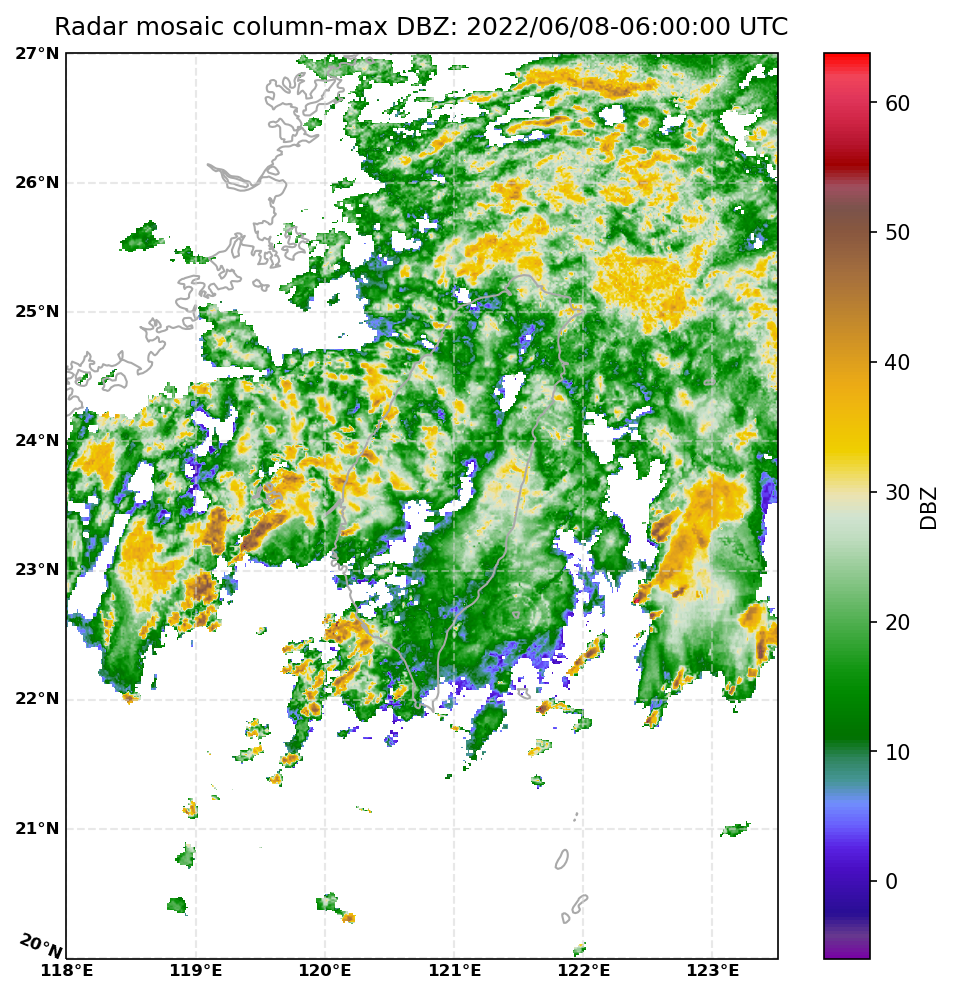

In [11]:
# Plot column-max reflectivity
fig1 = plt.figure(figsize=(8, 8), dpi=150)
ax1 = new_map(fig1)
plt.imshow(dbzPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic))
ax1.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical")
plt.title("Radar mosaic column-max DBZ: " + startTimeStr)

In [12]:
# Compute W-E DBZ vertical section
nYHalfMosaic = int(nYMosaic/2)
dbzVertWE = dbz3D[:, nYHalfMosaic:(nYHalfMosaic+1), :]
print(dbzVertWE.shape)
dbzVertWE = dbzVertWE.reshape(dbzVertWE.shape[0], dbzVertWE.shape[2])
print(dbzVertWE.shape)
dbzVertWE[dbzVertWE == fillValue] = np.nan
dbzWEMax = np.amax(dbz3D, (1))
dbzWEMax[dbzWEMax == fillValue] = np.nan

# Compute DBZ N-S vertical section
nXHalfMosaic = int(nXMosaic/2)
dbzVertNS = dbz3D[:, :, nXHalfMosaic:(nXHalfMosaic+1)]
dbzVertNS = dbzVertNS.reshape(dbzVertNS.shape[0], dbzVertNS.shape[1])
dbzVertNS[dbzVertNS == fillValue] = np.nan
print(dbzVertNS.shape)
dbzNSMax = np.amax(dbz3D, (2))
dbzNSMax[dbzNSMax == fillValue] = np.nan


(21, 1, 441)
(21, 441)
(21, 561)


Text(0.5, 1.0, 'Vert slice mid W-E DBZ: 2022/06/08-06:00:00 UTC')

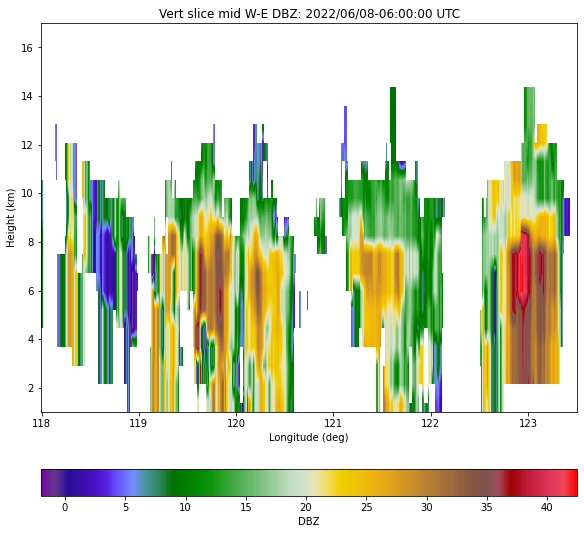

In [13]:
# Plot W-E DBZ vertical section
fig2 = plt.figure(num=2, figsize=[8, 8], layout='constrained')
ax2 = fig2.add_subplot(1, 1, 1, xlim = (minLonMosaic, maxLonMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertWE,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonMosaic, maxLonMosaic, minHtMosaic, maxHtMosaic))
ax2.set_aspect(0.25)
ax2.set_xlabel('Longitude (deg)')
ax2.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E DBZ: " + startTimeStr)

(21, 561)


Text(0.5, 1.0, 'Vert slice mid NS DBZ: 2022/06/08-06:00:00 UTC')

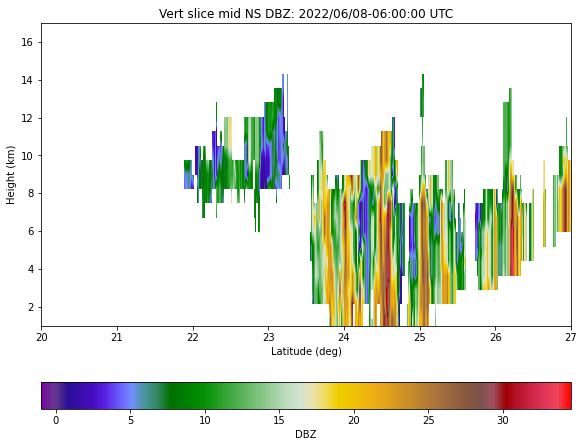

In [14]:
# Plot DBZ N-S vertical section
print(dbzVertNS.shape)
fig3 = plt.figure(num=3, figsize=[8, 8], layout='constrained')
ax3 = fig3.add_subplot(1, 1, 1, xlim = (minLatMosaic, maxLatMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertNS,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatMosaic, maxLatMosaic, minHtMosaic, maxHtMosaic))
ax3.set_aspect(0.25)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid NS DBZ: " + startTimeStr)

### Read in temperature field from GFS model, to provide temp profile for Ecco

In [15]:
# Read in temperature profile from GFS model

#dataDir = os.path.join(os.environ['HOME'], 'data') 
#filePathModel = os.path.join(dataDir, 'erad_lrose_workshop/data/gfs/20220608/20220608_120000.mdv.cf.nc')
filePathModel = '/tmp/lrose_data/taiwan_mrms/gfs/20220608/20220608_120000.mdv.cf.nc'
dsModel = nc.Dataset(filePathModel)
print(dsModel)
dstemp = dsModel['TMP']
temp3D = np.array(dstemp)
fillValuetemp = dstemp._FillValue
if (len(temp3D.shape) == 4):
    temp3D = temp3D[0]

# Compute Model grid limits
(nZModel, nYModel, nXModel) = temp3D.shape
lon = np.array(dsModel['x0'])
lat = np.array(dsModel['y0'])
ht = np.array(dsModel['z0'])
dLonModel = lon[1] - lon[0]
dLatModel = lat[1] - lat[0]
minLonModel = lon[0] - dLonModel / 2.0
maxLonModel = lon[-1] + dLonModel / 2.0
minLatModel = lat[0] - dLatModel / 2.0
maxLatModel = lat[-1] + dLatModel / 2.0
minHtModel = ht[0]
maxHtModel = ht[-1]
print("nZModel, nYModel, nXModel", nZModel, nYModel, nXModel)
print("minLonModel, maxLonModel: ", minLonModel, maxLonModel)
print("minLatModel, maxLatModel: ", minLatModel, maxLatModel)
print("minHt, maxHt: ", minHtModel, maxHtModel)
print("Model hts: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    source: Grib2
    title: GFS
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(400), y0(400), z0(29)
    variables(dimensions): float64 time(time), float64 forecast_reference_time(time), float64 forecast_period(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), float32 TMP(time, z0, y0, x0), float32 RH(time, z0, y0, x0), float32 UGRD(time, z0, y0, x0), float32 VGRD(time, z0, y0, x0), float32 HGT(time, z0, y0, x0), float32 Pressure(time, z0, y0, x0)
    groups: 
nZModel, nYModel, nXModel 29 400 400
minLonModel, maxLonModel:  99.95000076293945 139.94999313354492
minLatModel, maxLatModel:  4.950000047683716 44.95000147819519
minHt, maxHt:  0.0 18.0
Model hts:  [ 0.    0.25  0.5   0.75  1.    1.5   2.    2.5   3.    3.5   4.    4.5
  5.    5.5   6.    6.5   7.

### Compute N/S and W/E vertical sections for temperature, and plot

In [16]:
# Compute Temp N-S vertical section
nXHalfModel = int(nXModel/2)
tempVertNS = temp3D[:, :, nXHalfModel:(nXHalfModel+1)]
tempVertNS = tempVertNS.reshape(tempVertNS.shape[0], tempVertNS.shape[1])
tempVertNS[tempVertNS == fillValue] = np.nan
print(tempVertNS.shape)
tempNSMax = np.amax(temp3D, (2))
tempNSMax[tempNSMax == fillValue] = np.nan

# Compute Temp W-E vertical section
nYHalfModel = int(nYModel/2)
tempVertWE = temp3D[:, nYHalfModel:(nYHalfModel+1), :]
print(tempVertWE.shape)
tempVertWE = tempVertWE.reshape(tempVertWE.shape[0], tempVertWE.shape[2])
tempVertWE[tempVertWE == fillValue] = np.nan
tempWEMax = np.amax(temp3D, (1))
tempWEMax[tempWEMax == fillValue] = np.nan
print(tempVertWE.shape)

(29, 400)
(29, 1, 400)
(29, 400)


Text(0.5, 1.0, 'Vert slice mid W-E temp: 2022/06/08-06:00:00 UTC')

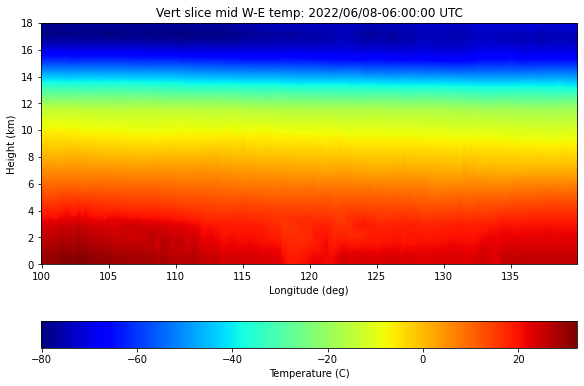

In [17]:
# Plot W-E temp vertical section
fig4 = plt.figure(num=4, figsize=[8, 8], layout='constrained')
ax4 = fig4.add_subplot(1, 1, 1, xlim = (minLonModel, maxLonModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertWE,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonModel, maxLonModel, minHtModel, maxHtModel))
ax4.set_aspect(1.0)
ax4.set_xlabel('Longitude (deg)')
ax4.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E temp: " + startTimeStr)

Text(0.5, 1.0, 'Vert slice mid N-S temp: 2022/06/08-06:00:00 UTC')

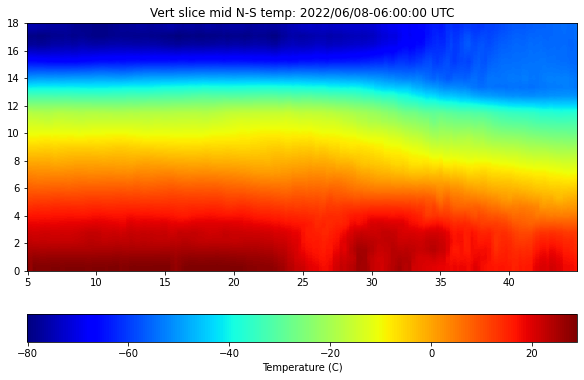

In [18]:
# Plot N-S temp vertical section
fig5 = plt.figure(num=5, figsize=[8, 8], layout='constrained')
ax5 = fig5.add_subplot(1, 1, 1, xlim = (minLatModel, maxLatModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertNS,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatModel, maxLatModel, minHtModel, maxHtModel))
ax3.set_aspect(0.25)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid N-S temp: " + startTimeStr)

### LROSE Parameter files

All LROSE applications have a detailed parameter file, which is read in at startup.

The parameters allow the user to control the processing in the LROSE apps.


### View the Ecco parameter file

The paths of the input files, and the output results file, are specified in the parameters.

Also included are all of the parameters used to control the algorithm.


In [19]:
# View the param file
!cat ./params/Ecco.mrms_taiwan

/**********************************************************************
 * TDRP params for Ecco
 **********************************************************************/

//======================================================================
//
// Program name: Ecco.
//
// Ecco finds convective and stratiform regions within a Cartesian radar 
//   volume.
//
//======================================================================
 
//======================================================================
//
// PROCESS CONTROL.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
//
// If set, debug messages will be printed appropriately.
//
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA
//

debug = DEBUG_OFF;

///////////// instance ////////////////////////////////
//
// Process instance.
//
// Used for registration with procmap.


### Run Ecco

We run Ecco by specifying the parameter file, and the start and end times for the analysis.

In [20]:
# Run Ecco using param file
!Ecco -params ./params/Ecco.mrms_taiwan -debug -start "2022 06 08 11 30 00" -end "2022 06 08 12 30 00"

Program 'Ecco'
Run-time 2022/08/18 20:54:54.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to confuse

### Read in Ecco results for a selected time

In [21]:
# Read in ecco results for a selected time
filePathEcco = '/tmp/lrose_data/taiwan_mrms/ecco/20220608/20220608_120000.mdv.cf.nc'
dsEcco = nc.Dataset(filePathEcco)
print(dsEcco)

# create 3D ecco type array with nans for missing vals

eccoField = dsEcco['EchoType3D']
ecco3D = np.array(eccoField)
fillValue = eccoField._FillValue
print("fillValue: ", fillValue)
print("ecco3D.shape: ", ecco3D.shape)

# if 4D (i.e. time is dim0) change to 3D
if (len(ecco3D.shape) == 4):
    ecco3D = ecco3D[0]

# Compute Ecco grid limits
(nZEcco, nYEcco, nXEcco) = ecco3D.shape
lon = np.array(dsEcco['x0'])
lat = np.array(dsEcco['y0'])
ht = np.array(dsEcco['z0'])
dLonEcco = lon[1] - lon[0]
dLatEcco = lat[1] - lat[0]
minLonEcco = lon[0] - dLonEcco / 2.0
maxLonEcco = lon[-1] + dLonEcco / 2.0
minLatEcco = lat[0] - dLatEcco / 2.0
maxLatEcco = lat[-1] + dLatEcco / 2.0
minHtEcco = ht[0]
maxHtEcco = ht[-1]
print("minLonEcco, maxLonEcco: ", minLonEcco, maxLonEcco)
print("minLatEcco, maxLatEcco: ", minLatEcco, maxLatEcco)
print("minHt, maxHt: ", minHtEcco, maxHtEcco)
print("ht: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/18 20:55:02
  Ncf:history: This MDV file was created by CwbRadar2Mdv.
  Ncf:comment: 
 : Stratfinder used to identify stratiform regions
    source: RCWF RCHL RCCG RCKT RCCK ISHI RCGI RCLY RCNT RCSL 
    title: 3D radar data mosaic from Taiwan CWB.
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(441), y0(561), x1(400), y1(400), z0(1), z1(29), z2(21), nbytes_mdv_chunk_0000(372)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 x1(x1), float32 y1(y1), float32 z0(z0), float32 z1(z1), float32 z2(z2), int32 grid_mapping_0(), int32 grid_mapping_1(), int32 mdv_master_header(time), int8 mdv_chunk_0000(time, nbytes_mdv_chunk_0000), int16 DbzTextureComp(time, z0, y0, x0), int16 ConvectivityComp(time, z0, y0, x0), int16 DbzComp(time, z0, y0

### Compute the column-max of the Ecco 3-D results 

In [22]:
# Compute column-max echo type
eccoPlaneMax = np.amax(ecco3D, (0))
eccoPlaneMax[eccoPlaneMax == fillValue] = np.nan
print(eccoPlaneMax.shape)
print(eccoPlaneMax[eccoPlaneMax != np.nan])
print(np.min(eccoPlaneMax[eccoPlaneMax != np.nan]))
print(np.max(eccoPlaneMax))

(561, 441)
[nan nan nan ... nan nan nan]
nan
nan


### Plot the column max of the Ecco results

Text(0.5, 1.0, 'Column max of Ecco results for radar mosaic: 2022/06/08-06:00:00 UTC')

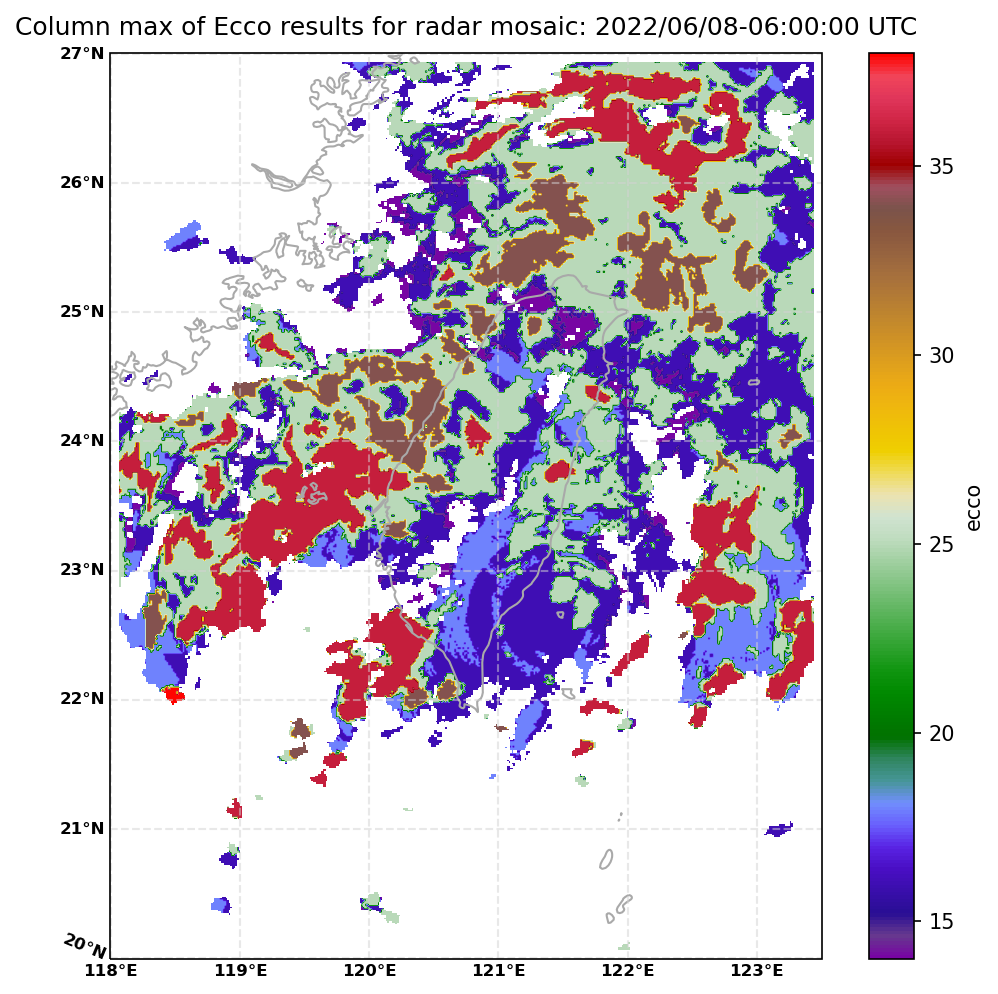

In [23]:
# Plot column-max ecco
fig6 = plt.figure(figsize=(8, 8), dpi=150)
ax6 = new_map(fig6)
plt.imshow(eccoPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonEcco, maxLonEcco, minLatEcco, maxLatEcco))
ax6.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="ecco", orientation="vertical")
plt.title("Column max of Ecco results for radar mosaic: " + startTimeStr)
